# Machine Vision<br>Assignment 1 - Imaging

## Personal details

* **Name:** `PUT YOUR NAME HERE.`
* **Student ID:** `PUT YOUR STUDENT ID HERE.`

## Introduction

This assignment explores the image processing pipeline of a digital color camera. The goal is to create a color image from the raw data captured with a smartphone. The figure below shows the image after each processing step. The raw sensor readings and metadata are saved as a DNG (digital negative) file. DNG is a lossless raw image format that is commonly used in digital photography. For your convenience, the raw image has been converted to NumPy array. The resolution of the original image is 3024 $\times$ 4032 pixels (16-Bit unsigned integer). To speed up the processing, the image has been cropped to 1000 $\times$ 1200 pixels. Before you continue, it is recommended that you go through the sample code __[`Imaging.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Imaging.ipynb)__ and the slides of lecture 2.

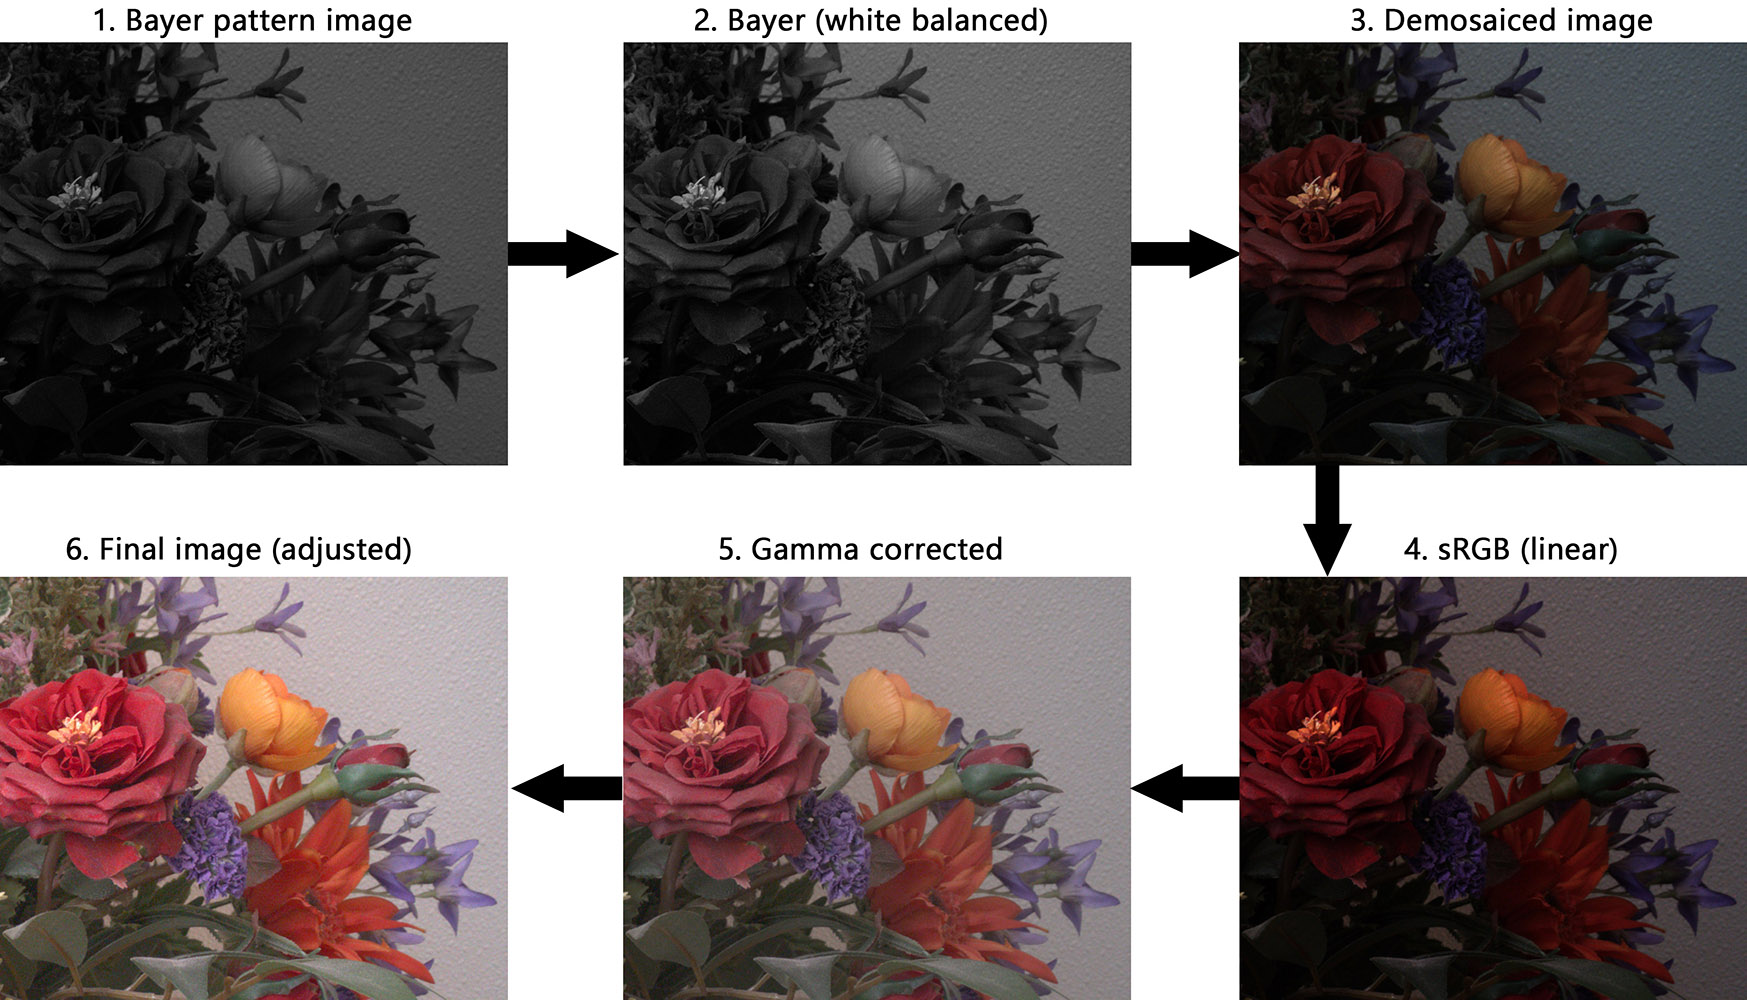

Let us first display the raw sensor image stored in `raw.npy`.

(-0.5, 1199.5, 999.5, -0.5)

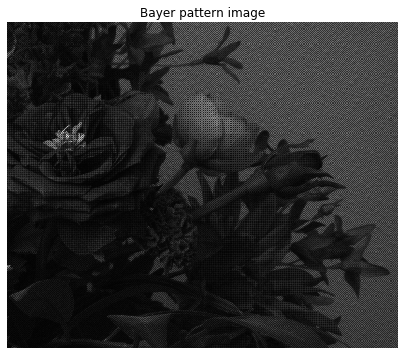

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

bayer = np.load('raw.npy')

plt.figure(figsize=(7,7))
plt.imshow(bayer, cmap='gray')
plt.title('Bayer pattern image')
plt.axis('off')

The image above is quite large so the Bayer filter pattern is not clearly visible. Here we display a smaller image patch.

(-0.5, 49.5, 49.5, -0.5)

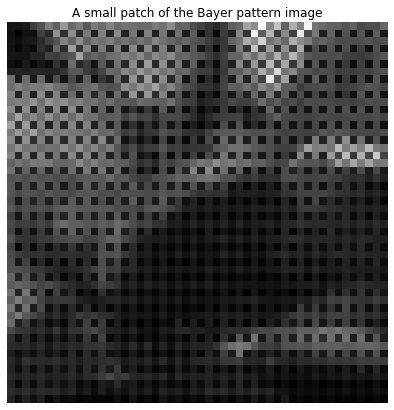

In [2]:
plt.figure(figsize=(7,7))
plt.imshow(bayer[350:400,150:200], cmap='gray')
plt.title('A small patch of the Bayer pattern image')
plt.axis('off')

## 1. Black level adjustment

Pixels that do not receive any light should have zero values. In practice, a dark current signal is still recorded even if the sensor does not receive any light. This leads to a slight offset that should be eliminated. To make sure that very dark regions of an image appear properly black, and that pixel values are in the range $[0,1]$, we can use the formula

$$
\bar{I}_{bayer} = \frac{I_{bayer} - b}{w - b}. \qquad (1)
$$

The Bayer pattern image is denoted by $I_{bayer}$. The black level $b$ and white level $w$ are typically stored in the DNG metadata.

**Eliminate the offset and scale** $\quad$ <font color=red>(0.50 points)</font>

Complete the following code cell. Normalize the raw image named `bayer` using Equation (1). Make sure the resulting values are in the range $[0,1]$ by clipping. You can use `np.clip()` similar to the sample code __[`Imaging.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Imaging.ipynb)__. Name the resulting image `bayer_norm` and display. It should look very similar to the image we already displayed. This is because, by default, *plt.imshow()* maps the lowest value to 0 and the highest to 1.

(-0.5, 49.5, 49.5, -0.5)

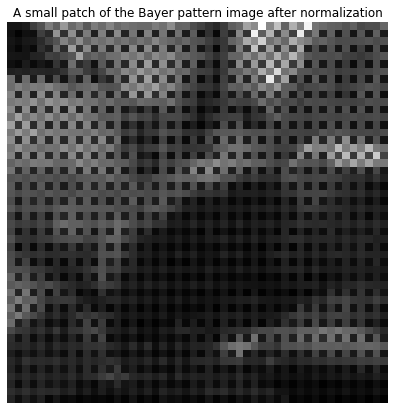

In [3]:
black_level = 51.5553
white_level = 1023

# ---------- YOUR CODE STARTS HERE -----------

bayer_norm = (bayer-black_level)/(white_level-black_level)

bayer_norm=np.clip(bayer_norm,0,1)
plt.figure(figsize=(7,7))
plt.imshow(bayer_norm[350:400,150:200], cmap='gray')
plt.title('A small patch of the Bayer pattern image after normalization')
plt.axis('off')

# ----------- YOUR CODE ENDS HERE ------------

# print(bayer_norm.max()) # Don't mind this

## 2. White balance

To white balance an image, we need to scale each color channel in the CFA (color filter array) by appropriate amounts. The scale factors are defined in the DNG metadata. The scaling of the green channel (or any other channel) can be set to 1 since only the ratio of the three colors matters. The CFA for the given camera is shown below.

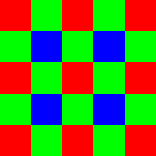


**Perform white balancing** $\quad$ <font color=red>(0.50 points)</font>

Complete the following code cell. Perform white balancing using the scale factors `wb_coeff`. That is, pixels with red color filter should be multiplied by $1.8023$ and blue pixels by $2.1695$. There is no need to scale green pixels. After white balancing, make sure that values are in the range $[0,1]$ by clipping. Name the output image `bayer_wb` and display. The image should still look very similar to the previous step.

(-0.5, 299.5, 249.5, -0.5)

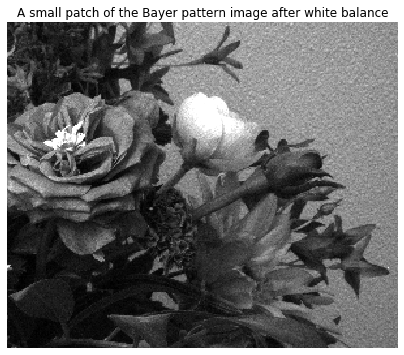

In [63]:
wb_coeff = np.array([1.8028, 1.0000, 2.1695], dtype=np.float32)

# ---------- YOUR CODE STARTS HERE -----------

bayer_wb = bayer_norm.copy() # You may not need this line

bayer_wb=wb_coeff[0]*bayer_norm[::2,::2]
bayer_wb=wb_coeff[2]*bayer_norm[1::2,1::2]

bayer_wb=np.clip(bayer_wb,0,1)
plt.figure(figsize=(7,7))
# plt.imshow(bayer_wb[350:400,150:200], cmap='gray')
plt.imshow(bayer_wb, cmap='gray')

plt.title('A small patch of the Bayer pattern image after white balance')
plt.axis('off')




# ----------- YOUR CODE ENDS HERE ------------

# print(bayer_wb.max()) # Don't mind this

(-0.5, 299.5, 249.5, -0.5)

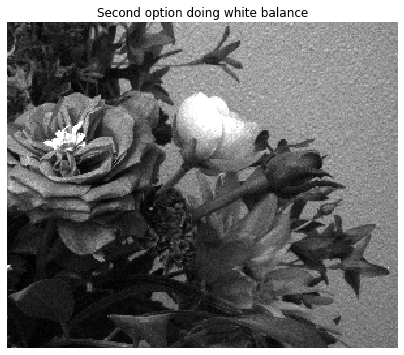

In [69]:
# This was done for verification purposes

bayer_wb2 = bayer_norm.copy()

bmask = np.zeros((2,2,1))

bmask[0,0] = wb_coeff[0]
bmask[0,1] = 1
bmask[1,0] = 1
bmask[1,1] = wb_coeff[2]

bpattern = np.kron(np.ones((int((bayer_wb2.shape[0]/2)), int(bayer_wb2.shape[1]/2), 1)), bmask).astype(np.uint8)

bayer_wb2 = np.squeeze(bayer_wb2).shape

bayer_wb2 = bayer_wb2 * bpattern

bayer_wb2 = np.clip(bayer_wb,0,1)

plt.figure(figsize=(7,7))
plt.imshow(bayer_wb2, cmap='gray')

plt.title('Second option doing white balance')
plt.axis('off')

**Tips:** 
- Option 1: Familiarize yourself with Python slice notation. For example, to multiply red pixels, you can write `wb_coeff[0]*bayer_norm[::2,::2]`.

- Option 2: Create a 2 $\times$ 2 matrix [R G; G B] from the coefficients. Repeat the matrix vertically  and horizontally to create H $\times$ W white balance mask, where H and W denote the height and width of the image, respectively. This can be done using `np.kron()` similar to the sample code __[`Imaging.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Imaging.ipynb)__. Then, white balance by multiplying `bayer_norm` with the mask.


## 3. Demosaicing

Demosaicing techniques make use of pixel's neighborhood to estimate the color values that were not measured. There exist many demosaicing algorithms but here we utilize the one from OpenCV. The output is an RGB image with three channels. The image produced will be in the color space of the camera.

**Run the code below**

Once you have completed previous steps, run the code below. **Note that you should remove the first line**. You will see that `cam_rgb` is a color image. However, the image is dark and colors are not quite right.

(-0.5, 299.5, 249.5, -0.5)

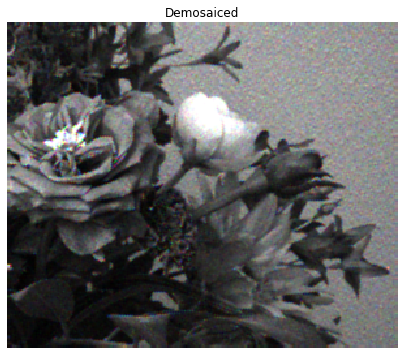

In [70]:
# REMOVE / COMMENT the following line
#bayer_wb = np.ones_like(bayer)

# Convert to uint16
bayer_uint16 = (65535*bayer_wb).astype(np.uint16)

# Demosaicing (float is not supported)
cam_uint16 = cv2.cvtColor(bayer_uint16, cv2.COLOR_BayerBG2RGB)

# Convert back to float. Range [0,1].
cam_rgb = (cam_uint16/65535).astype(np.float32)

plt.figure(figsize=(7,7))
plt.imshow(cam_rgb)
plt.title('Demosaiced')
plt.axis('off')

## 4. Color space conversions

At the moment, the pixel values are in the camera's color space. We need to apply a linear transformation to convert the colors to the CIE XYZ color space. CIE XYZ is a device independent color space. The 3 $\times$ 3 transformation matrix, later denoted by `cam2xyz` can be obtained from the DNG metadata. 

We also need to perform another transformation from CIE XYZ color space to the desired output space (sRGB). This transformation matrix is named `xyz2rgb`.

Let us define a function that transforms an image from one color space to another. The function takes a three channel image and 3 $\times$ 3 transformation matrix as input.

In [50]:
def apply_cmatrix(img, cmatrix):
    
    r = cmatrix[0,0]*img[:,:,0]+cmatrix[0,1]*img[:,:,1]+cmatrix[0,2]*img[:,:,2]
    g = cmatrix[1,0]*img[:,:,0]+cmatrix[1,1]*img[:,:,1]+cmatrix[1,2]*img[:,:,2]
    b = cmatrix[2,0]*img[:,:,0]+cmatrix[2,1]*img[:,:,1]+cmatrix[2,2]*img[:,:,2]
    
    img_cvt = np.dstack((r,g,b))
    
    return img_cvt

**4.1. Covert to CIE XYZ color space** $\quad$ <font color=red>(0.25 points)</font>

Complete the following code cell. Convert `cam_rgb` to CIE XYZ color space by using the function `apply_cmatrix`. After that, make sure that values are in the range $[0,1]$ by clipping. Name the output `xyz` and display.

In [56]:
# Transformation matrix (Camera RGB -> CIE XYZ)
cam2xyz = np.array([[0.5533, 0.1456, 0.3011],
                    [0.1905, 0.6709, 0.1386],
                    [-0.0043, -0.2105, 1.2148]])

# ---------- YOUR CODE STARTS HERE -----------

xyz = apply_cmatrix(cam_rgb, cam2xyz)
xyz = np.clip(xyz,0,1)


# ----------- YOUR CODE ENDS HERE ------------

# print(xyz.max(axis=(0,1))) # Don't mind this

**Note** 
- The output `xyz` will not look any better because CIE XYZ color space is not intented for viewing purposes.

**4.2. Covert to sRGB color space** $\quad$ <font color=red>(0.25 points)</font>

Complete the following code cell. Convert `xyz` to sRGB color space by using the function `apply_cmatrix`. After that, make sure that values are in the range $[0,1]$ by clipping. Name the output `srgb` and display.

In [57]:
xyz2rgb = np.array([[3.240479, -1.53715, -0.498535],
                    [-0.969256, 1.875991, 0.041556],
                    [0.055648, -0.204043, 1.057311]])

# ---------- YOUR CODE STARTS HERE -----------

srgb = apply_cmatrix(xyz, xyz2rgb)
srgb = np.clip(srgb,0,1)


# ----------- YOUR CODE ENDS HERE ------------

# print(srgb.max(axis=(0,1))) # Don't mind this

## 5. Gamma correction

Now the image is in the right color space for display. However, the image appears dark since the intensity scale is linear. Humans do not sense brightness on a linear scale. The relationship follows approximately a power function

$$
I_{brightness} = I_{linear}^{\gamma}. \qquad (2)
$$

**Perform gamma correction** $\quad$ <font color=red>(0.50 points)</font>

Complete the following code cell. Use Equation (2) to gamma correct `srgb` image. Set $\gamma=\frac{1}{2.2}$. Name the output `srgb_gamma` and display.

(-0.5, 299.5, 249.5, -0.5)

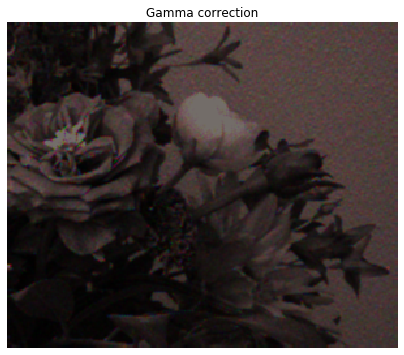

In [58]:
# ---------- YOUR CODE STARTS HERE -----------

srgb_gamma = srgb * (1/2.2)


plt.figure(figsize=(7,7))
plt.imshow(srgb_gamma)
plt.title('Gamma correction')
plt.axis('off')

# ----------- YOUR CODE ENDS HERE ------------

# print(srgb_gamma.max(axis=(0,1))) # Don't mind this

## 6. Further adjustments (optional)

An actual camera pipeline built-in to the device might include various post-processing steps. For example, color artifact removal and edge enhancement are commonly employed. Note also that we skipped a few steps at the beginning of the pipeline, mainly vignetting correction and denoising. The following code improves the appearance of the image by simply increasing the brightness and saturation. Run the code by changing the first line to `if True:`.

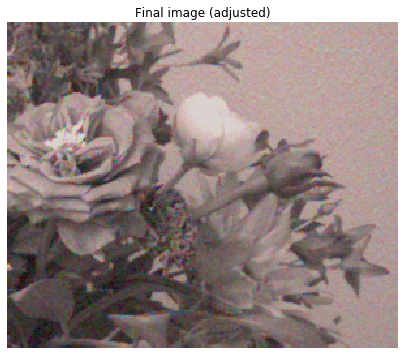

In [59]:
if True:

    # Increase brightness
    gray = cv2.cvtColor(srgb, cv2.COLOR_RGB2GRAY)
    scaling = 0.25/np.mean(gray.ravel())
    srgb_bright = np.clip(scaling*srgb, 0, 1)
    srgb_bright_gamma = srgb_bright ** (1/2.2)

    # Increase saturation
    hsv = cv2.cvtColor(srgb_bright_gamma, cv2.COLOR_RGB2HSV)
    hsv_adj = hsv.copy()
    hsv_adj[:,:,1] = 1.2*hsv[:,:,1]
    hsv_adj[:,:,1] = np.clip(hsv_adj[:,:,1], 0, 1)
    srgb_adj = cv2.cvtColor(hsv_adj, cv2.COLOR_HSV2RGB)

    plt.figure(figsize=(7,7))
    plt.imshow(srgb_adj)
    plt.title('Final image (adjusted)')
    plt.axis('off')

# Aftermath
Finally, fill your answers to the following questions:

**How much time did you need to complete this exercise?**

`REPLACE THIS TEXT WITH YOUR ANSWER.`

**Did you experience any problems with the exercise? Was there enough help available? Should this notebook be more (or less) detailed?**

`REPLACE THIS TEXT WITH YOUR ANSWER.`

# References
`LIST YOUR POSSIBLE REFERENCES HERE.`

# Submission

1. Click on the menu `Kernel -> Restart & Clear Output` to clear all outputs and variables, etc.
2. Compress the resulting Jupyter notebook (`MV_A1.ipynb` file) into **`MV_A1_[student number(s)].zip`** (e.g. `MV_A1_1234567.zip` if solo work or `MV_A1_1234567-7654321.zip` if pair work).
3. Send an email to janne.mustaniemi@oulu.fi with the subject line `MV_A1_[student number(s)]`. Remember to attach the .zip file.

**Deadline of the assignment 22.1.2020**